<a href="https://colab.research.google.com/github/HazemAbdo/FloodSense/blob/classification%2Fdeep_learning/SI_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources:
* https://arxiv.org/pdf/2105.08655.pdf
* https://sahilkhose.medium.com/paper-presentation-e9bd0f3fb0bf
* https://towardsdatascience.com/binary-image-classification-in-pytorch-5adf64f8c781
* https://www.mdpi.com/2073-4441/15/5/875

# Imports

In [114]:
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torchvision import datasets, transforms,models
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid

In [115]:
!pip install opencv-python-headless
!pip install tqdm
#tqdm is a Python package that provides a progress bar for iterative tasks
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Helpers

In [117]:
def show_img(img,title=""):
   plt.imshow(img)
   plt.title(title)
   plt.show()

In [118]:
def extract_file(zip_path,specified_directory):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(specified_directory)


In [119]:
def read_images( flooded_path,non_flooded_path,width,height):
    flooded = np.empty((0, width, height, 3))
    non_flooded = np.empty((0, width, height, 3))

    for filename in os.listdir(flooded_path):
        img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (width, height)) 
        img = img.astype('float32') / 255.0 
        img = np.expand_dims(img, axis=0)
        flooded = np.concatenate((flooded, img), axis=0)

    for filename in os.listdir(non_flooded_path):
        img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (width, height)) 
        img = img.astype('float32') / 255.0  
        img = np.expand_dims(img, axis=0) 
        non_flooded = np.concatenate((non_flooded, img), axis=0)
    return flooded,non_flooded

In [120]:
def show_images(images,images_labels):
  nrows = 4
  ncols = 4
  fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
  ax = ax.flatten()
  for i in range(nrows*ncols):
      pic = images[i%8]
      ax[i].imshow(pic)
      ax[i].set_title(images_labels[i%8])
      ax[i].set_axis_off()
  plt.show()

In [141]:
def evaluate(y,y_pred,model_name):
    cm = confusion_matrix(y, y_pred)
    cr = classification_report(y, y_pred)
    fn = cm[1][0]
    pos = cm[1][0] + cm[1][1]
    omission_error = fn / pos
    fp = cm[0][1]
    neg = cm[0][0] + cm[0][1]
    commission_error = fp / neg
    print(f"Model: {model_name}")
    print(cm)
    print(cr)
    print("Omission error rate:", omission_error)
    print("Commission error rate:", commission_error)
    

# Images reading 

In [121]:
extract_file("drive/MyDrive/Copy of dataset.zip","/content")

In [122]:
flooded,non_flooded=read_images("dataset/flooded","dataset/non-flooded",224,224)
print("flooded images shapes",flooded.shape)
print("non_flooded images shapes",non_flooded.shape)

flooded images shapes (461, 224, 224, 3)
non_flooded images shapes (461, 224, 224, 3)


In [123]:
def split_data(shuffle=False,stratify=False):
  stratify_1=None
  stratify_2=None

  X = np.concatenate((flooded, non_flooded), axis=0)
  y = np.concatenate((np.ones(flooded.shape[0]), np.zeros(non_flooded.shape[0])), axis=0)
  if stratify:
    stratify_1=y
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=shuffle,stratify=stratify_1,random_state=42)
  if stratify:
    stratify_2=y_test
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,shuffle=shuffle,stratify=stratify_2,random_state=42)
  return X_train, X_test,X_val, y_train, y_test,y_val

In [124]:
  X_train, X_test,X_val, y_train, y_test,y_val=split_data(shuffle=True,stratify=True)
  print(X_train.shape, y_train.shape)  
  print(X_test.shape, y_test.shape)  
  print(X_val.shape, y_val.shape) 

(737, 224, 224, 3) (737,)
(93, 224, 224, 3) (93,)
(92, 224, 224, 3) (92,)


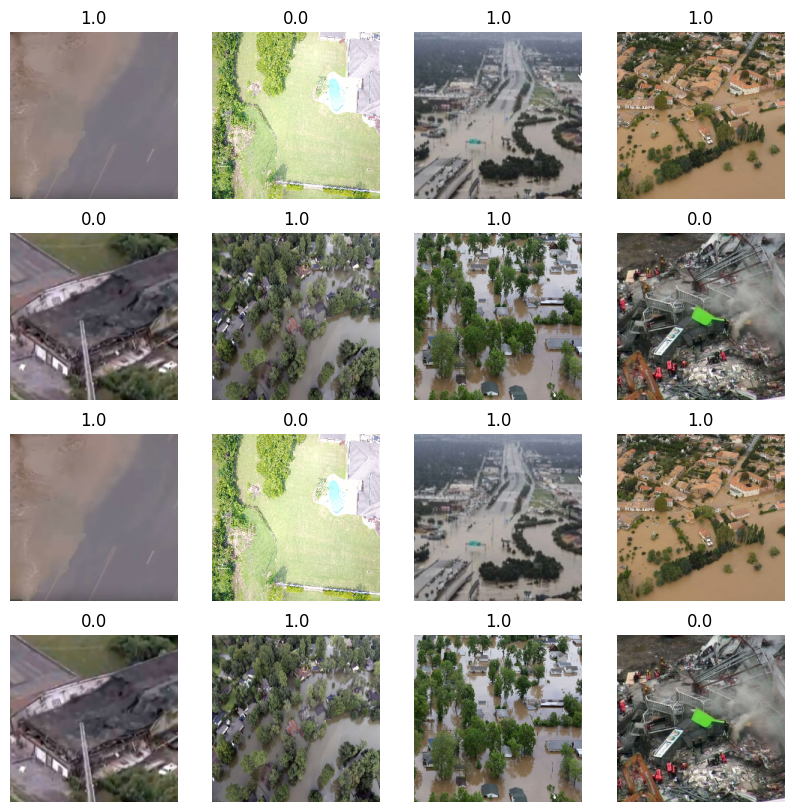

In [125]:
show_images(X_train,y_train)

# Deep-learning approach

In [126]:
def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64, data_augmentation=True):
    # convert the numpy arrays to PyTorch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()
    X_val_tensor = torch.from_numpy(X_val).float()
    y_val_tensor = torch.from_numpy(y_val).float()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).float()

    # create a PyTorch dataset from the tensors
    if data_augmentation:
        train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=(-45, 45)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            )
        ])
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_dataset.transforms = train_transforms
    else:
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # create a PyTorch DataLoader for the training set
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # create a PyTorch DataLoader for the validation set
    validationloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # create a PyTorch DataLoader for the test set
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return trainloader, validationloader, testloader

In [127]:
trainloader, validationloader, testloader=create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64,data_augmentation=True)

In [128]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #optimizer.cleargrads()

    return loss
  return train_step

In [129]:
def create_resnet18_model(num_classes=1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = models.resnet18(pretrained=True)
    # model = models.resnet18(pretrained=False)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Add a new final layer
    num_filters = model.fc.in_features
    model.fc = nn.Linear(num_filters, num_classes)

    # Move the model to the selected device
    model = model.to(device)

    return model

In [130]:
def create_resnet50_model(num_classes=1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = models.resnet50(pretrained=True)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Add a new final layer
    num_filters = model.fc.in_features
    model.fc = nn.Linear(num_filters, num_classes)

    # Move the model to the selected device
    model = model.to(device)

    return model

In [131]:
#num_classes in last layer 1 as it's binary classifcation problem
model = create_resnet18_model(num_classes=1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [132]:
#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model
#optimizer
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01) 
#train step
train_step = make_train_step(model, optimizer, loss_fn)

In [133]:
def train_model(model, trainloader, validationloader, optimizer, loss_fn, n_epochs=20, early_stopping_tolerance=3, early_stopping_threshold=0.03):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    best_loss = float("inf")
    best_model_wts = None
    early_stopping_counter = 0
    losses = []
    val_losses = []
    epoch_train_losses = []
    epoch_val_losses = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
            x_batch, y_batch = data
            x_batch = x_batch.permute(0, 3, 1, 2)
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float()
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            model.train()
            yhat = model(x_batch)
            loss = loss_fn(yhat, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() / len(trainloader)
            losses.append(loss.item())

        epoch_train_losses.append(epoch_loss)
        print('\nEpoch : {}, train loss : {}'.format(epoch+1, epoch_loss))

        with torch.no_grad():
            cum_loss = 0
            for x_batch, y_batch in validationloader:
                x_batch = x_batch.permute(0, 3, 1, 2)
                x_batch = x_batch.to(device)
                y_batch = y_batch.unsqueeze(1).float()
                y_batch = y_batch.to(device)

                model.eval()
                yhat = model(x_batch)
                val_loss = loss_fn(yhat, y_batch)
                cum_loss += val_loss.item() / len(validationloader)
                val_losses.append(val_loss.item())

            epoch_val_losses.append(cum_loss)
            print('Epoch : {}, val loss : {}'.format(epoch+1, cum_loss))

            if cum_loss <= best_loss:
                best_loss = cum_loss
                best_model_wts = model.state_dict()
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter == early_stopping_tolerance or best_loss <= early_stopping_threshold:
                print("\nTerminating: early stopping")
                break

    model.load_state_dict(best_model_wts)
    return model, losses, val_losses, epoch_train_losses, epoch_val_losses

In [139]:
# # Define parameter grid
# param_grid = {
#     'n_epochs': [30, 50, 100],
#     'early_stopping_tolerance': [2, 3, 5],
#     'early_stopping_threshold': [0.02, 0.03, 0.05]
# }

# # Generate all combinations of hyperparameters
# param_list = list(ParameterGrid(param_grid))

# # Train and evaluate the model for each parameter combination
# best_model = None
# best_loss = float("inf")
# best_params = {}
# for params in param_list:
#     print("Training model with params:", params)
#     model, _, _, _, epoch_val_losses = train_model(model, trainloader, validationloader, optimizer, loss_fn, **params)
#     final_loss = epoch_val_losses[-1]
#     print("Validation loss:", final_loss)
#     if final_loss < best_loss:
#         best_loss = final_loss
#         best_model = model
#         best_params = params

# print("Best model validation loss:", best_loss)
# print("Best model hyperparameters:", best_params)

* Best model validation loss: 0.14393571391701698
* Best model hyperparameters: {'early_stopping_threshold': 0.05, 'early_stopping_tolerance': 2, 'n_epochs': 100}

In [135]:
model, losses, val_losses, epoch_train_losses, epoch_val_losses = train_model(model, trainloader, validationloader, optimizer, loss_fn,n_epochs=100,early_stopping_tolerance=2,early_stopping_threshold=0.05)

100%|██████████| 12/12 [00:01<00:00,  9.18it/s]



Epoch : 1, train loss : 0.08217416393260162
Epoch : 1, val loss : 0.14278022572398186


100%|██████████| 12/12 [00:01<00:00, 10.04it/s]



Epoch : 2, train loss : 0.09219935784737267
Epoch : 2, val loss : 0.14043502509593964


100%|██████████| 12/12 [00:01<00:00, 10.63it/s]



Epoch : 3, train loss : 0.0856066392734647
Epoch : 3, val loss : 0.13984806090593338


100%|██████████| 12/12 [00:01<00:00, 10.64it/s]



Epoch : 4, train loss : 0.0859168463697036
Epoch : 4, val loss : 0.1460897959768772


100%|██████████| 12/12 [00:01<00:00, 10.61it/s]



Epoch : 5, train loss : 0.08008215607454379
Epoch : 5, val loss : 0.1429249346256256

Terminating: early stopping


In [143]:
def test_model(loader, model, device,model_name):
    got_sample=False
    estimated = []
    true = []
    images_classified_flooded = []
    images_classified_non_flooded = []
    for x_batch, y_batch in loader:
        x_batch = x_batch.permute(0, 3, 1, 2)
        x_batch = x_batch.to(device)
        y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
        y_batch = y_batch.to(device)
        model.eval()
        yhat = model(x_batch)
        yhat = torch.sigmoid(yhat)
        yhat = torch.round(yhat)
        if not got_sample:
            got_sample = True
            for i in range(len(yhat)):
                if yhat[i] == 1:
                    images_classified_flooded.append(x_batch[i].permute(1, 2, 0).cpu().detach().numpy())
                else:
                    images_classified_non_flooded.append(x_batch[i].permute(1, 2, 0).cpu().detach().numpy())
        estimated.append(yhat.cpu().detach().numpy())
        true.append(y_batch.cpu().detach().numpy())
    estimated = np.concatenate(estimated, axis=0)
    true = np.concatenate(true, axis=0)
    evaluate(true,estimated,model_name)
    return images_classified_flooded,images_classified_non_flooded

In [144]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_images_classified_flooded,train_images_classified_non_flooded=(test_model(
    trainloader,model,device,"ResNet18 on train data"
))
test_images_classified_flooded,test_images_classified_non_flooded=(test_model(
    testloader,model,device,"ResNet18 on test data"
))

Model: ResNet18 on train data
[[367   1]
 [  5 364]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       368
         1.0       1.00      0.99      0.99       369

    accuracy                           0.99       737
   macro avg       0.99      0.99      0.99       737
weighted avg       0.99      0.99      0.99       737

Omission error rate: 0.013550135501355014
Commission error rate: 0.002717391304347826
Model: ResNet18 on test data
[[46  1]
 [ 3 43]]
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96        47
         1.0       0.98      0.93      0.96        46

    accuracy                           0.96        93
   macro avg       0.96      0.96      0.96        93
weighted avg       0.96      0.96      0.96        93

Omission error rate: 0.06521739130434782
Commission error rate: 0.02127659574468085


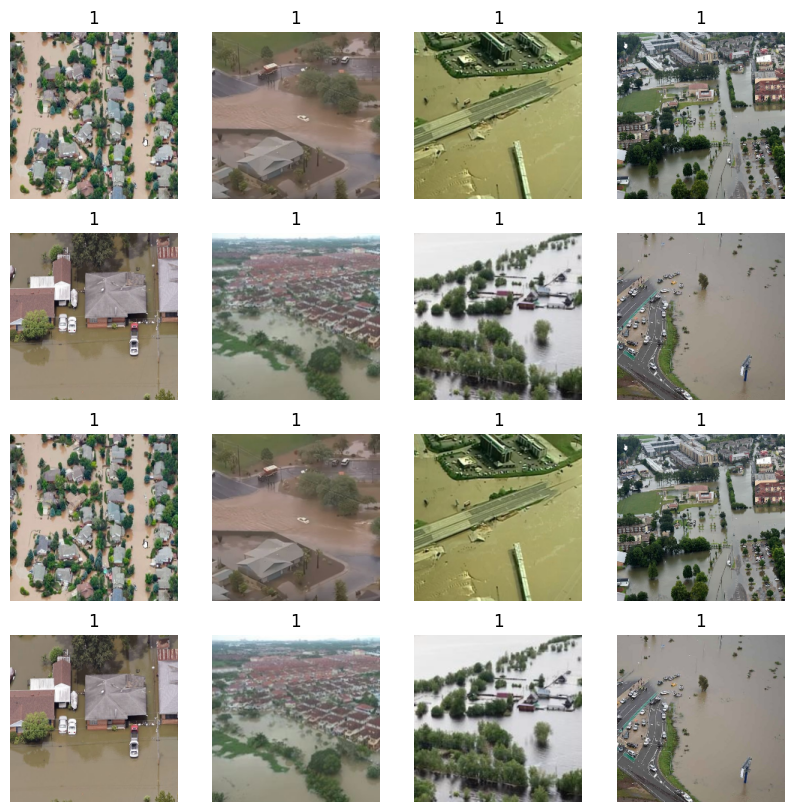

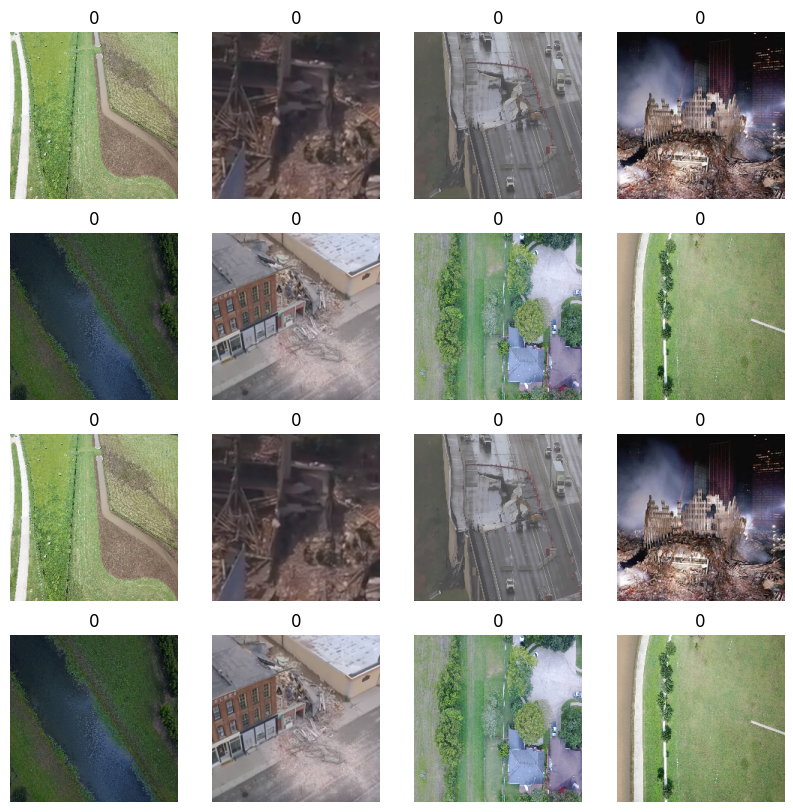

In [145]:
show_images(train_images_classified_flooded[0:16],[1]*16)
show_images(train_images_classified_non_flooded[0:16],[0]*16)

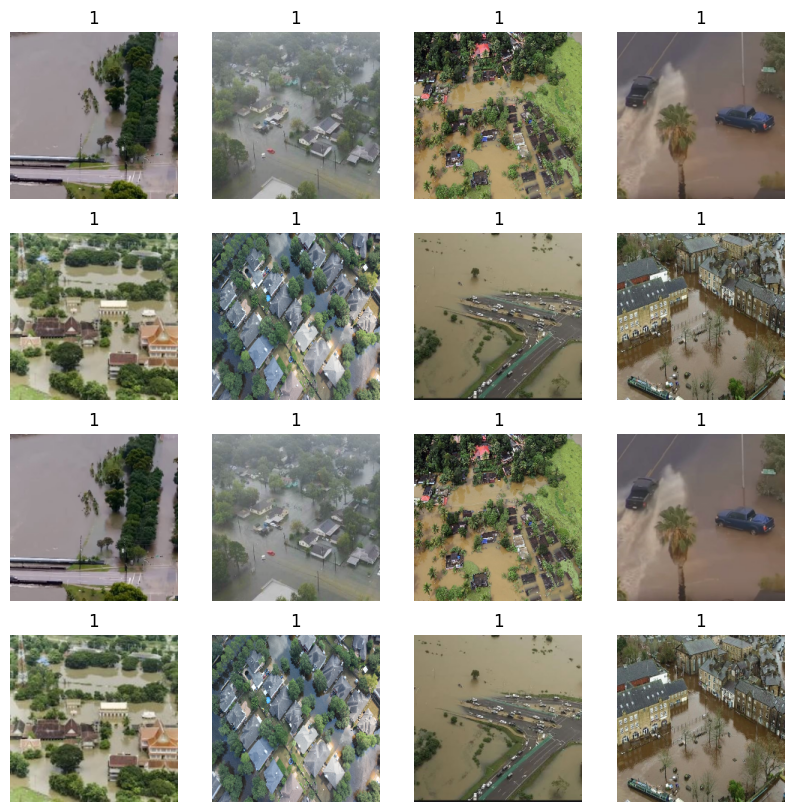

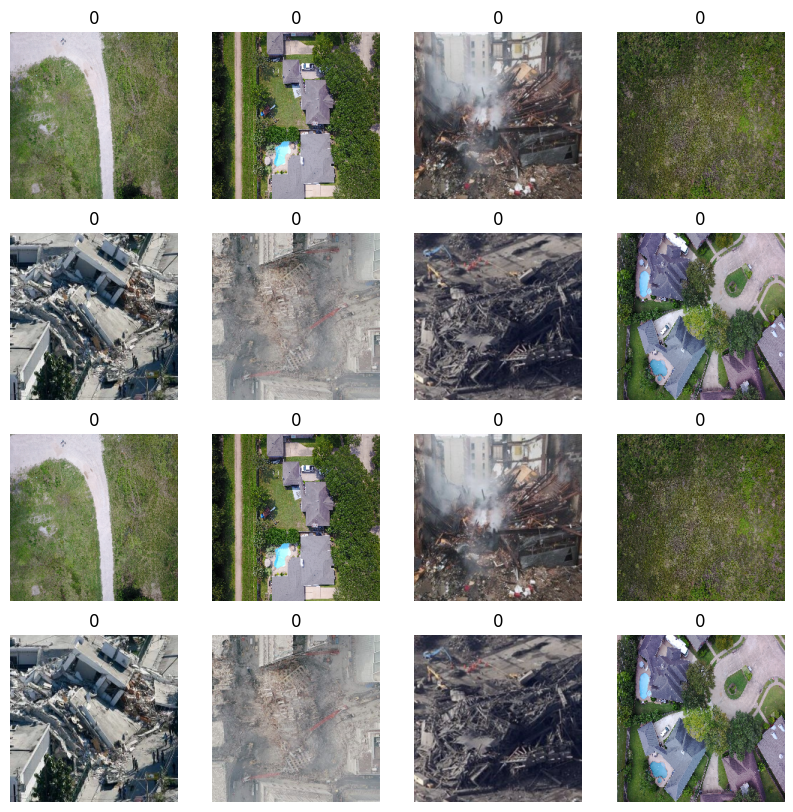

In [146]:
show_images(test_images_classified_flooded[0:16],[1]*16)
show_images(test_images_classified_non_flooded[0:16],[0]*16)